In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import cv2 as cv
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models

In [14]:
# import helper_functions

# Images and Convolutions
### The simple, complex and convoluted notions behind computer vision
## Part 2 - Convolutional neural networks

#### Helper functions

In [ ]:
def plot_image_subplots(
        images, 
        titles=None, 
        subplot_kwargs=None, 
        nrows=1, 
        ncols=3, 
        figsize_hor=12, 
        figsize_ver=6, 
        no_ticks=True
    ):
    """
    Plots a grid of images with titles, allowing for different keyword arguments for each subplot.

    Example usage:
    plot_image_subplots(
        images=[image_1, image_2, image_3],
        titles=["Title 1", "Title 2", "Title 3"],
        plot_kwargs=[
            {"cmap": "gray"},
            {"cmap": "Reds_r", "vmin": 0, "vmax": 1},
            {"cmap": "Blues_r", "vmin": -1, "vmax": 1}
        ],
        nrows=1,
        ncols=3,
        figsize_hor=15,
        figsize_ver=5
    )
    """
    if titles is None:
        titles = ["" for _ in images]
    else:
        assert len(images) == len(titles), "Number of images not equal to number of titles"

    if subplot_kwargs is None:
        subplot_kwargs = [{} for _ in images]
    else:
        assert len(images) == len(subplot_kwargs), "Number of images not equal to number of plot_kwargs"

    for kwargs in subplot_kwargs:
        if "cmap" not in kwargs:
            kwargs["cmap"] = "gray"

    fig, axs = plt.subplots(nrows, ncols, figsize=(figsize_hor, figsize_ver))
    axs = axs.flatten()

    for i, (image, title) in enumerate(zip(images, titles)):
        axs[i].imshow(image, **subplot_kwargs[i])
        axs[i].set_title(title)

    if no_ticks:
        plt.setp(axs, xticks=[], yticks=[])

    plt.tight_layout()
    plt.show()


In [ ]:

def limit_range(pixel_value, min_value = 0, max_value = 1): 
    """
    Function to keep the range of pixel values; (0, 1) by default
    """ 
    if pixel_value < min_value:
        pixel_value = min_value
    elif pixel_value > max_value:
        pixel_value = max_value
    return pixel_value

limit_range = np.vectorize(limit_range)

In [ ]:
def convolve_3_channel_image(image, filter):
    """
    Applies scipy.ndimage.convolve(image_channel, filter) separately on each channel of the image and
    returns the resulting convolutions stacked to resemble a color image.
    """
    return np.dstack([convolve(image[:, :, i], filter) for i in range(3)])

In [ ]:
def plot_convolutions(image, filters, titles = None, subplot_kwargs = None, single_channel = True, **plot_kwargs):
    """
    Plot images resulting from convolution with given filters.
    """
    if single_channel:
        conv_results = [convolve(image, filter) for filter in filters]
    else:
        conv_results = [convolve_3_channel_image(image, filter) for filter in filters]
        

    plot_image_subplots(conv_results, titles, subplot_kwargs, **plot_kwargs)

In [ ]:
def plot_heatmaps(arrays, titles = None, nrows = 1, ncols = 2, figsize_hor = 12, figsize_ver = 3, cmap_limit = 0.1):
    """
    Plots a heatmap of each array with a common colorbar. 
    Heatmaps are zero-centered, blue indicating negative values, red - positive.

    """
    if titles is None:
        titles = ["" for _ in arrays]
    else:
        assert len(arrays) == len(titles), "Number of arrays not equal to number of titles"

    # Create the figure and axes
    fig, axs = plt.subplots(nrows, ncols, figsize = (figsize_hor, figsize_ver), layout = "compressed")
    if len(arrays) > 1:
        axs = axs.flatten()
    else:
        axs = [axs]

    # Find the global min and max values across all data for common scaling
    global_min = min(data.min() for data in arrays)
    global_max = max(data.max() for data in arrays)

    global_abs = max([abs(global_min), global_max])

    # Create a common normalization
    norm = TwoSlopeNorm(vmin = - cmap_limit - global_abs, vmax = cmap_limit + global_abs, vcenter = 0)

    # Plot each data array
    for ax, array, title in zip(axs, arrays, titles):
        cax = ax.imshow(array, cmap = "seismic", norm = norm)
        ax.set_title(title)
    
    # Add a single colorbar
    cbar = fig.colorbar(cax, ax=axs[:len(arrays)])
    
    # Remove axis ticks
    plt.setp(axs, xticks=[], yticks=[])
    
 
    plt.show()


Our cat ir rather unfit for the purpose of demonstrating how convolutional neural networks work. That is we would need vastly greater number of cats to make it work. Further more, recognizing a cat is a hard task - there are a lot of other things with eyes, nose and fur, so we would need wide and deep neural network and a lot of images, time, knowledge and skill to train it (and we have neither of those). So we will take the simplest image dataset in existense - MNIST, which happens to be readily available in Tensorflow Datasets. It consists of small grayscale images of handwritten digits, annotated which digit it is supposed to be.
We load our dataset, normalize pixel values and add an extra dimension, because expected shape for an image is (w,h, ch).

In [2]:
# Load and preprocess the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0



In [3]:
train_images.shape

(60000, 28, 28)

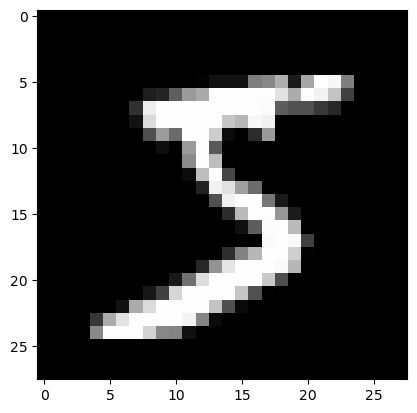

In [4]:
plt.imshow(train_images[0], cmap="gray")

In [5]:
# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

In [6]:

# Convert labels to binary: 1 for class '8', 0 for others
train_labels = (train_labels == 8).astype(int)
test_labels = (test_labels == 8).astype(int)

: 

In [7]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(1, (3, 3), activation='relu', input_shape=(28, 28, 1)), # Single convolutional layer with one 3 x 3 filter
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  # Single output neuron for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')


In [ ]:
test_images[0].shape

In [ ]:
idx_to_plot = range(4*8)
images_to_plot = np.array([test_images[i] for i in idx_to_plot])
predictions = model.predict(images_to_plot)
titles = [f"{prob[0]:.4f}" for prob in predictions.tolist()]


NameError: name 'model' is not defined

In [ ]:
plot_image_subplots(images_to_plot, titles=titles, nrows = 4, ncols = 8)

NameError: name 'plot_image_subplots' is not defined

In [1]:
conv_layer = model.layers[0]
kernel_weights, bias = conv_layer.get_weights()
kernel_weights.shape

NameError: name 'model' is not defined

In [ ]:
conv_filter = kernel_weights.reshape((3,3))
plot_heatmaps([conv_filter], ncols=1)

In [ ]:
images_to_plot = np.array([convolve(test_images[i], conv_filter) for i in idx_to_plot])